In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, KFold, GridSearchCV)
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix)
from imutils import paths
import cv2
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile
import io
import os
import seaborn as sns

In [2]:
url = "https://github.com/10sajan10/CS6830_Project7/raw/main/sateliteimage.zip"

response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall()
        print(f"Files extracted")

Download successful!
Files extracted


In [3]:
def extract_color_stats(image):

    B, G, R = cv2.split(image)

    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    std_R, std_G, std_B = np.std(R), np.std(G), np.std(B)

    features = [mean_R, mean_G, mean_B, std_R, std_G, std_B]

    return features

In [4]:
imagePaths = paths.list_images(r'sateliteimage/')
data = []
labels_str = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    features = extract_color_stats(image)
    data.append(features)

    # extract the class label from the file path and update the labels list
    label = imagePath.split(os.path.sep)[-2].split("/")[1]
    labels_str.append(label)

le = LabelEncoder()
labels = le.fit_transform(labels_str)

In [5]:
df = pd.DataFrame(data, columns=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'])
df['label'] = labels_str

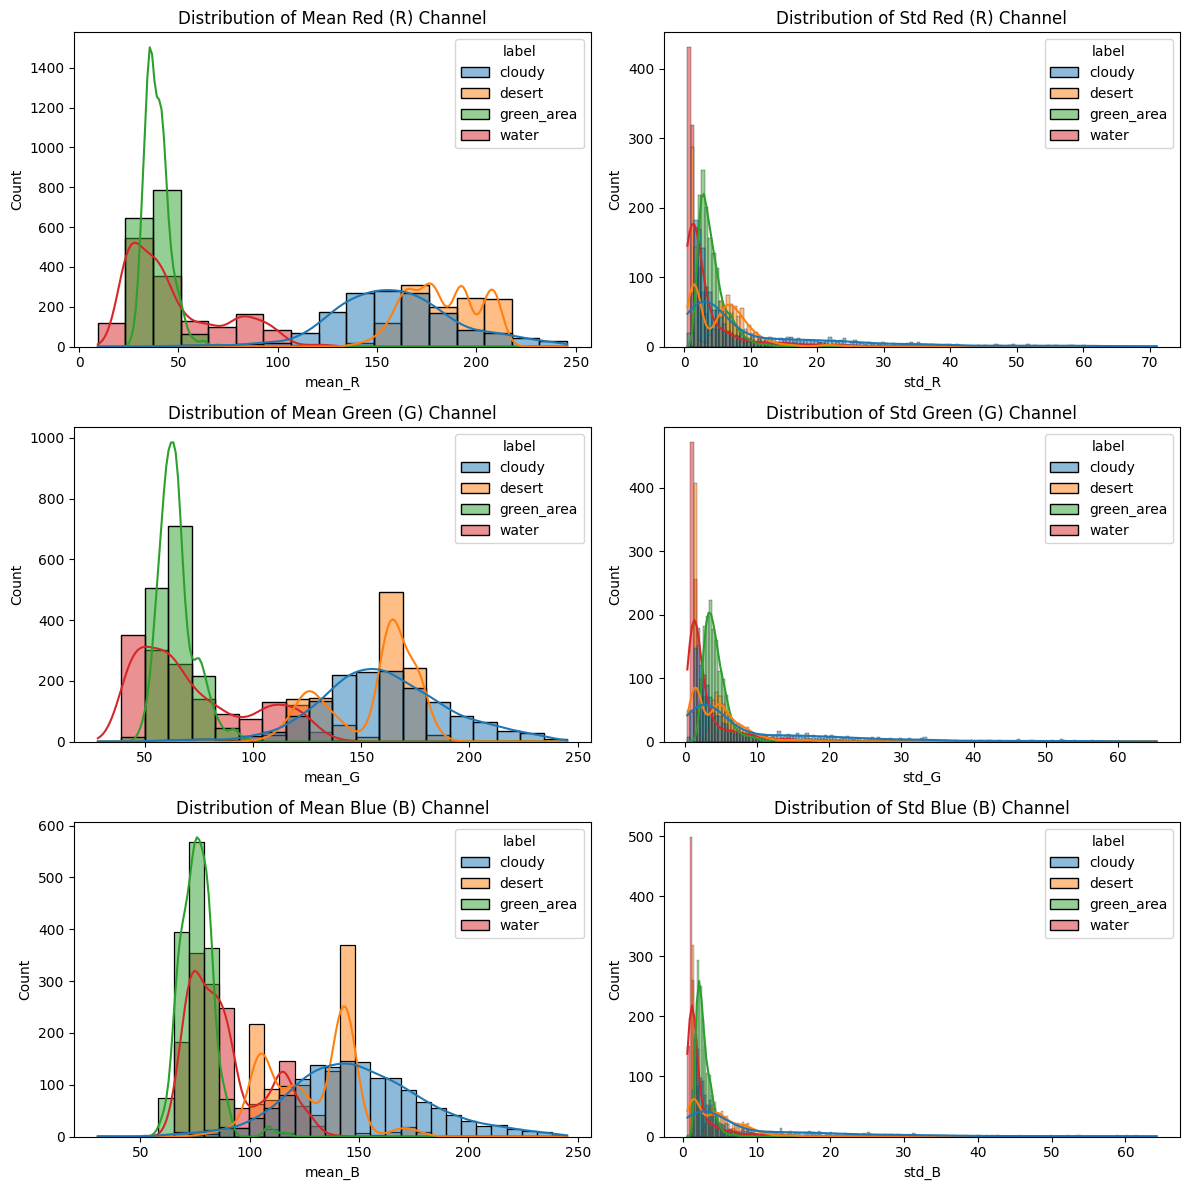

In [6]:
plt.figure(figsize=(12, 12))

# Plot for mean(R)
plt.subplot(3, 2, 1)
sns.histplot(data=df, x='mean_R', hue='label', kde=True)
plt.title('Distribution of Mean Red (R) Channel')

# Plot for std(R)
plt.subplot(3, 2, 2)
sns.histplot(data=df, x='std_R', hue='label', kde=True)
plt.title('Distribution of Std Red (R) Channel')

# Plot for mean(G)
plt.subplot(3, 2, 3)
sns.histplot(data=df, x='mean_G', hue='label', kde=True)
plt.title('Distribution of Mean Green (G) Channel')

# Plot for std(G)
plt.subplot(3, 2, 4)
sns.histplot(data=df, x='std_G', hue='label', kde=True)
plt.title('Distribution of Std Green (G) Channel')

# Plot for mean(B)
plt.subplot(3, 2, 5)
sns.histplot(data=df, x='mean_B', hue='label', kde=True)
plt.title('Distribution of Mean Blue (B) Channel')

# Plot for std(B)
plt.subplot(3, 2, 6)
sns.histplot(data=df, x='std_B', hue='label', kde=True)
plt.title('Distribution of Std Blue (B) Channel')

plt.tight_layout()
plt.show()

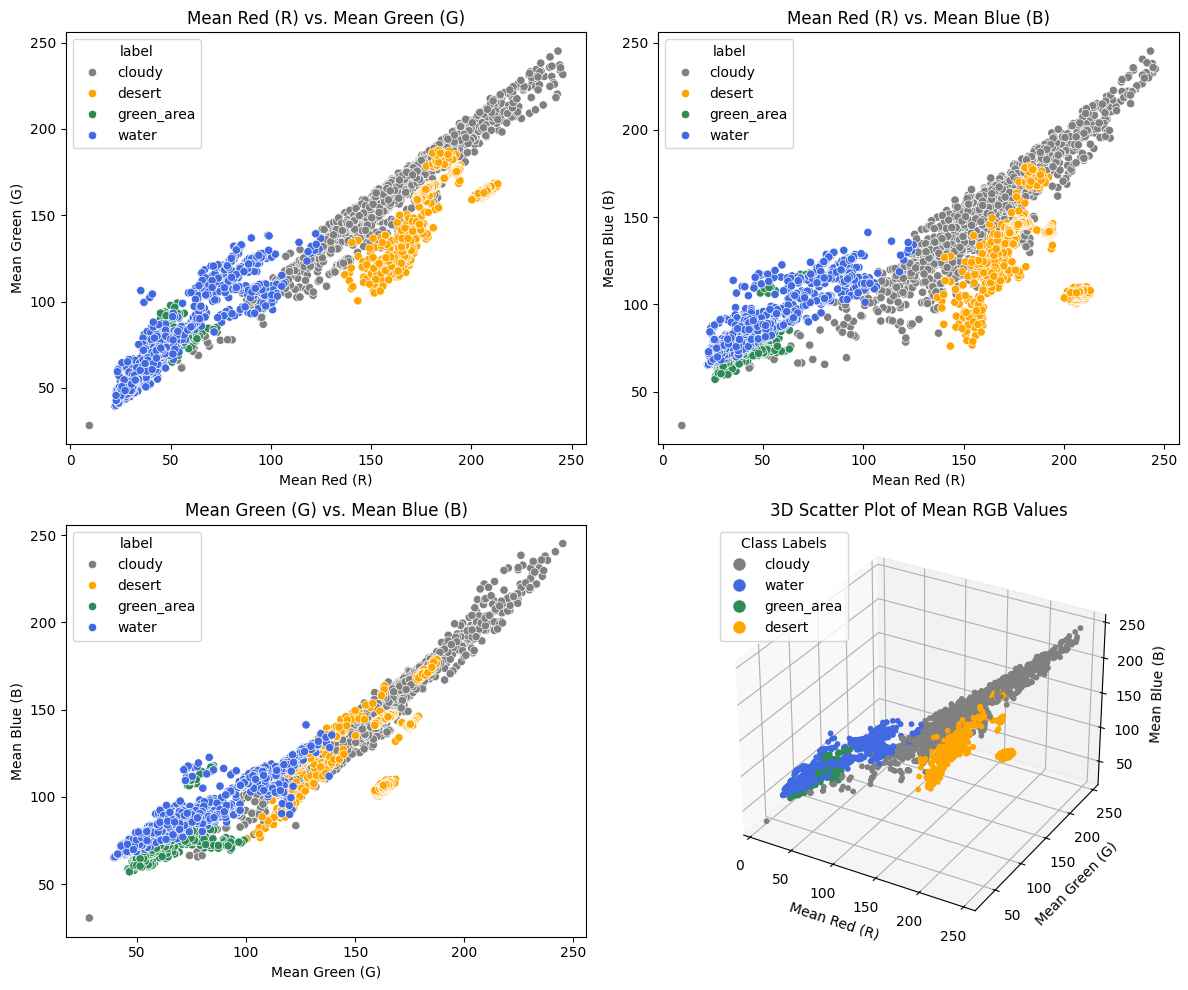

In [7]:
plt.figure(figsize=(12, 10))
color_mapping = {
    'cloudy': 'gray',
    'water': 'royalblue',
    'green_area': 'seagreen',
    'desert': 'orange'
}
df['color'] = df['label'].map(color_mapping)

# Plot for mean_R vs mean_G
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='mean_R', y='mean_G', hue='label', palette=color_mapping)
plt.title('Mean Red (R) vs. Mean Green (G)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Green (G)')

# Plot for mean_R vs mean_B
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='mean_R', y='mean_B', hue='label', palette=color_mapping)
plt.title('Mean Red (R) vs. Mean Blue (B)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Blue (B)')

# Plot for mean_G vs mean_B
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='mean_G', y='mean_B', hue='label', palette=color_mapping)
plt.title('Mean Green (G) vs. Mean Blue (B)')
plt.xlabel('Mean Green (G)')
plt.ylabel('Mean Blue (B)')


ax = plt.subplot(2, 2, 4, projection='3d')  # Set the 3D projection here

# Scatter plot with specified colors
ax.scatter(df['mean_R'], df['mean_G'], df['mean_B'], 
           color=df['color'],  # Use the color from the mapping
           s=10,  # Size of points
           alpha=1)  # Transparency

# Labels
ax.set_xlabel('Mean Red (R)')
ax.set_ylabel('Mean Green (G)')
ax.set_zlabel('Mean Blue (B)')
ax.set_title('3D Scatter Plot of Mean RGB Values')

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10) 
           for label in color_mapping]
ax.legend(handles, color_mapping.keys(), title="Class Labels")

plt.tight_layout()
plt.show()

In [53]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
trainscore = {}
test_accuracy = {}
test_precision = {}
test_recall = {}
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
scores = cross_val_score(log_reg, trainX, trainY, cv=cv)
trainscore['Logistic_Regression'] = scores.mean()

In [54]:
import time
start_time = time.time()
log_reg.fit(trainX, trainY)
end_time = time.time()


In [55]:
print(f'Runtime = {end_time-start_time}')

Runtime = 0.14530682563781738


Confusion Matrix of Logistic Regression:
[[299  21   8   0]
 [ 10 217   0   0]
 [  0   0 220  64]
 [  2   0  62 224]]


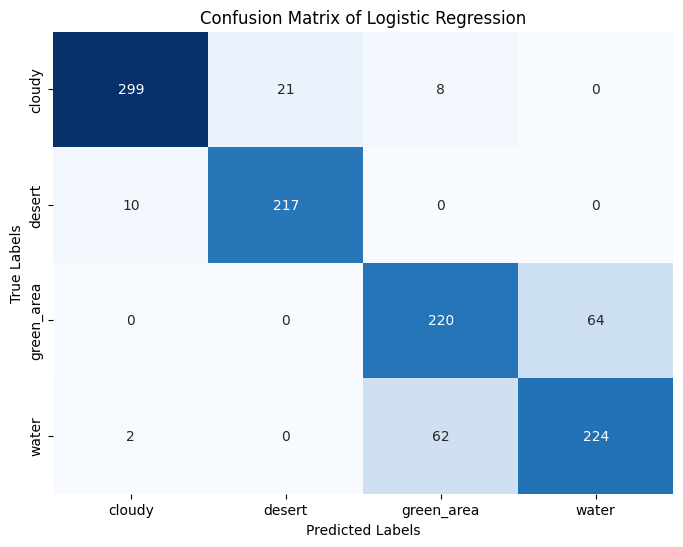

In [56]:

predicted_test_labels = log_reg.predict(testX)
conf_matrix = confusion_matrix(testY, predicted_test_labels)
print("Confusion Matrix of Logistic Regression:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [57]:
test_accuracy['Logistic_Regression'] = accuracy_score(testY, predicted_test_labels)
test_precision['Logistic_Regression'] = precision_score(testY, predicted_test_labels, average='weighted')
test_recall['Logistic_Regression'] = recall_score(testY, predicted_test_labels, average='weighted')

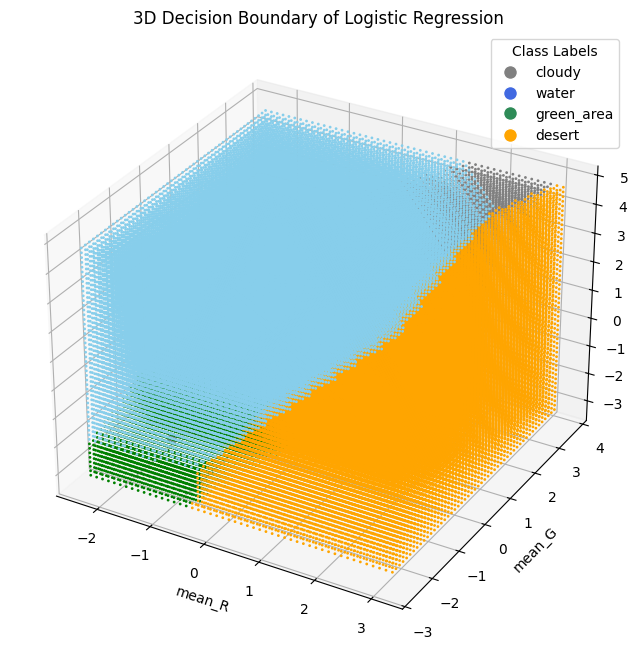

In [60]:
label_mapping ={0:'gray',1:'orange',2:'green',3:'skyblue'}
# Fit the logistic regression model
log_reg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
log_reg.fit(trainX[:,:3], trainY)

# Create a mesh grid for the two features (let's say the first two features)
x_min, x_max = trainX[:, 0].min() - 1, trainX[:, 0].max() + 1
y_min, y_max = trainX[:, 1].min() - 1, trainX[:, 1].max() + 1
z_min, z_max = trainX[:, 2].min() - 1, trainX[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 50),
                     np.linspace(y_min, y_max, 50), np.linspace(z_min, z_max, 50))
data_mesh =np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
# Predict using the mesh grid, fixing the third feature to its mean value
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
# Z = Z.reshape(xx.shape)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the decision boundary
# ax.plot_surface(xx, yy, zz, Z, alpha=0.5, cmap='coolwarm', edgecolor='none')

# Scatter plot for the original training data points
ax.scatter(trainX[:, 0], trainX[:, 1], trainX[:, 2], 
           c=[label_mapping[label] for label in trainY], 
           alpha=1, s=40, label='Training Data')
ax.scatter(data_mesh[:, 0], data_mesh[:, 1], data_mesh[:, 2], c=pd.Series(Z).apply(lambda x: label_mapping[x]), alpha = 1, s=1,)
# Labels and title
ax.set_xlabel('mean_R')
ax.set_ylabel('mean_G')
ax.set_zlabel('mean_B')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10) 
           for label in color_mapping]
ax.legend(handles, color_mapping.keys(), title="Class Labels")
ax.set_title('3D Decision Boundary of Logistic Regression')
plt.show()

In [14]:
svc = SVC(random_state=42)
param_grid = [
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [0.1, 1, 10, 100, 1000], 'degree': [1, 2, 3], 'kernel': ['poly']}]
grid = GridSearchCV(svc, param_grid, refit=True, verbose=3)
grid.fit(trainX, trainY)
print(grid.best_params_)
print(grid.best_score_)
trainscore['SVC'] = grid.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.363 total time=   2.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.375 total time=   2.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.368 total time=   2.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.368 total time=   2.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.374 total time=   2.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.811 total time=   1.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.828 total time=   1.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.851 total time=   1.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.802 total time=   1.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.811 total time=   1.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.931 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

Confusion Matrix of SVC:


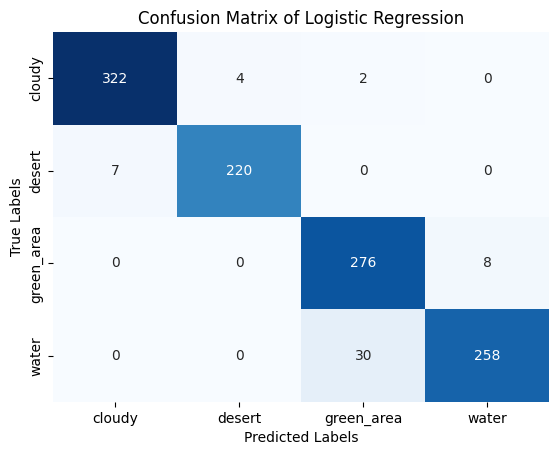

In [15]:
predicted_labels = grid.predict(testX)
test_accuracy['SVC'] = accuracy_score(testY, predicted_labels)
test_precision['SVC'] = precision_score(testY, predicted_labels, average='weighted')
test_recall['SVC'] = recall_score(testY, predicted_labels, average='weighted')
print("Confusion Matrix of SVC:")
conf_matrix=confusion_matrix(testY, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [16]:
df_scores = pd.DataFrame({'Train Accuracy': trainscore, 'Test Accuracy': test_accuracy, 
                          'Test Precision': test_precision,'Test Recall': test_recall})
df_scores

,Train Accuracy,Test Accuracy,Test Precision,Test Recall
Logistic_Regression,0.849018,0.851819,0.853383,0.851819
SVC,0.956927,0.954747,0.956344,0.954747


In [17]:
df

,mean_R,mean_G,mean_B,std_R,std_G,std_B,label,color
0,213.562683,199.237503,199.536819,20.310541,13.928131,28.346747,cloudy,gray
1,165.971985,174.197098,167.876984,2.602291,2.167828,2.246940,cloudy,gray
2,164.004395,165.285370,148.799866,4.682241,4.030938,4.132139,cloudy,gray
3,156.863953,152.975510,141.959076,3.389826,3.330366,3.502315,cloudy,gray
4,164.201797,146.248596,127.623993,1.068016,0.993032,1.442419,cloudy,gray
...,...,...,...,...,...,...,...,...
5626,25.770264,50.684570,79.875000,0.719228,1.026084,1.109045,water,royalblue
5627,27.290283,48.419678,69.861084,0.943710,0.920095,1.043717,water,royalblue
5628,32.346924,54.523682,80.112793,1.233883,1.893638,1.228317,water,royalblue
5629,51.185059,69.609863,81.430664,1.861653,1.847095,1.443289,water,royalblue


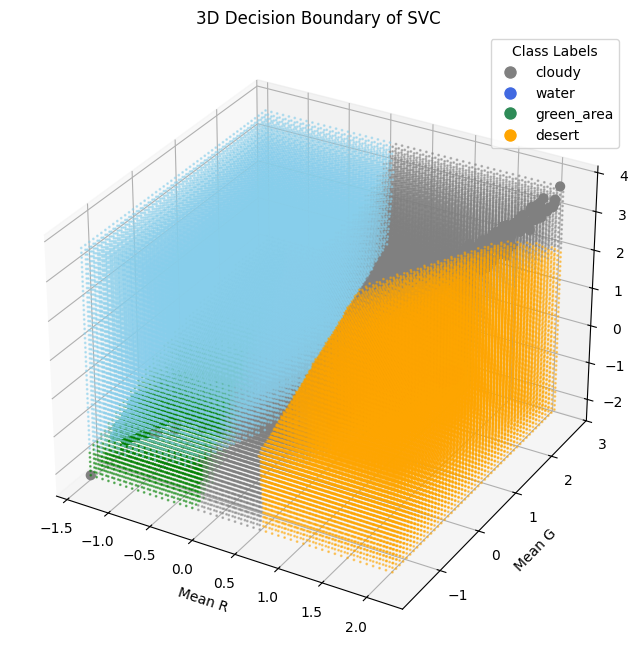

In [64]:
label_mapping = {0: 'gray', 1: 'orange', 2: 'green', 3: 'skyblue'}

svc = SVC(C=10, gamma=0.01, kernel='rbf', random_state=42)
svc.fit(trainX[:,:3], trainY)

x_min, x_max = trainX[:, 0].min(), trainX[:, 0].max()
y_min, y_max = trainX[:, 1].min() , trainX[:, 1].max()
z_min, z_max = trainX[:, 2].min(), trainX[:, 2].max()

xx, yy, zz = np.meshgrid(
    np.linspace(x_min, x_max, 50),
    np.linspace(y_min, y_max, 50),
    np.linspace(z_min, z_max, 50)
)

data_mesh = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = svc.predict((data_mesh))  # Transform the mesh grid for predictions

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the original training data points
ax.scatter(trainX[:, 0], trainX[:, 1], trainX[:, 2], 
           c=[label_mapping[label] for label in trainY], 
           alpha=1, s=40, label='Training Data')

# Visualize the decision boundary
ax.scatter(data_mesh[:, 0], data_mesh[:, 1], data_mesh[:, 2], 
           c=[label_mapping[label] for label in Z], 
           alpha=0.5, s=1)

# Labels and title
ax.set_xlabel('Mean R')
ax.set_ylabel('Mean G')
ax.set_zlabel('Mean B')
ax.set_title('3D Decision Boundary of SVC')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10) 
           for label in color_mapping]
ax.legend(handles, color_mapping.keys(), title="Class Labels")

plt.show()

In [52]:
df_scores

,Train Accuracy,Test Accuracy,Test Precision,Test Recall
Logistic_Regression,0.849018,0.851819,0.853383,0.851819
SVC,0.956927,0.954747,0.956344,0.954747


In [65]:
from sklearn.svm import LinearSVC
linear_svc = LinearSVC(random_state=42)

# Define the parameter grid for LinearSVC, only including the 'C' parameter
param_grid = [{'C': [0.1, 1, 10, 100, 1000]}]

# Set up GridSearchCV
grid = GridSearchCV(linear_svc, param_grid, refit=True, verbose=3)

# Fit the model to the training data
grid.fit(trainX, trainY)

# Output the best parameters and best score
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# Store the best score in trainscore
trainscore['LinearSVC'] = grid.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............................C=0.1;, score=0.826 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.848 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.856 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.841 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.829 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.827 total time=   0.0s
[CV 2/5] END ...............................C=1;, score=0.851 total time=   0.0s
[CV 3/5] END ...............................C=1;, score=0.861 total time=   0.0s
[CV 4/5] END ...............................C=1;, score=0.840 total time=   0.0s
[CV 5/5] END ...............................C=1;, score=0.829 total time=   0.0s
[CV 1/5] END ..............................C=10;, score=0.830 total time=   0.0s
[CV 2/5] END ..............................C=10;,

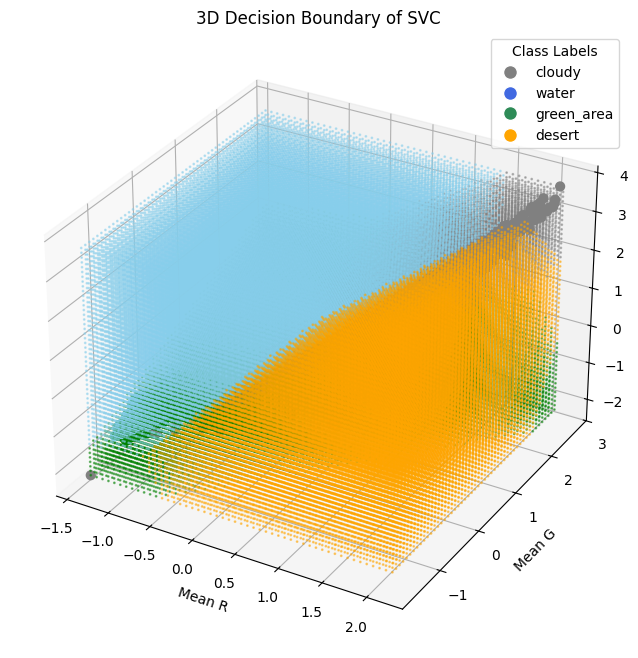

In [69]:
label_mapping = {0: 'gray', 1: 'orange', 2: 'green', 3: 'skyblue'}

lin_svc = LinearSVC(C=1000, random_state=42)
lin_svc.fit(trainX[:,:3], trainY)

x_min, x_max = trainX[:, 0].min(), trainX[:, 0].max()
y_min, y_max = trainX[:, 1].min() , trainX[:, 1].max()
z_min, z_max = trainX[:, 2].min(), trainX[:, 2].max()

xx, yy, zz = np.meshgrid(
    np.linspace(x_min, x_max, 50),
    np.linspace(y_min, y_max, 50),
    np.linspace(z_min, z_max, 50)
)

data_mesh = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = lin_svc.predict((data_mesh))  # Transform the mesh grid for predictions

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the original training data points
ax.scatter(trainX[:, 0], trainX[:, 1], trainX[:, 2], 
           c=[label_mapping[label] for label in trainY], 
           alpha=1, s=40, label='Training Data')

# Visualize the decision boundary
ax.scatter(data_mesh[:, 0], data_mesh[:, 1], data_mesh[:, 2], 
           c=[label_mapping[label] for label in Z], 
           alpha=0.5, s=1)

# Labels and title
ax.set_xlabel('Mean R')
ax.set_ylabel('Mean G')
ax.set_zlabel('Mean B')
ax.set_title('3D Decision Boundary of SVC')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10) 
           for label in color_mapping]
ax.legend(handles, color_mapping.keys(), title="Class Labels")

plt.show()